In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import pvlib
from sklearn.ensemble import RandomForestRegressor as RF 
import matplotlib
% matplotlib notebook
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [2]:
path = 'PV_data'

In [3]:
def discrete_cmap(N, base_cmap='hsv'):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    m = round(N/2)-1
    color_list = np.concatenate([color_list[m::-1],color_list[:m:-1]])
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [4]:
panel_out = pd.read_csv(os.path.join(path, 'data_out.csv'))
panel_out['time'] = pd.to_datetime(panel_out.time)
panel_out.set_index('time', inplace = True)

In [5]:
# pre-processing:
# - aggregate to hourly values: 
# 1. take mean over date, hour
# 2. adjust values:
# temp:          mean
# precipitation: sum (multiply by 6)
# GHI:           mean
# sunshine_dur:  sum (multiply by 6)
# power_output:  mean

In [6]:
panel_out['hour'] = panel_out.index.hour
panel_out['date'] = panel_out.index.date

In [7]:
panel_out

,DHI,GHI,precipitation,sunshine_dur,temp,apparent_zenith,azimuth,DNI,irradiance,power_output,PV_noise,power_output_noisy,hour,date
time,,,,,,,,,,,,,,
2016-01-01 00:00:00,1.0,2.0,0.0,0.0,3.9,154.801403,16.981575,0.0,1.031955,5.417765,0.272463,5.145303,0,2016-01-01
2016-01-01 00:10:00,1.0,2.0,0.0,0.0,3.9,154.234825,22.163115,0.0,1.034692,5.432134,0.109197,5.322937,0,2016-01-01
2016-01-01 00:20:00,1.0,2.0,0.0,0.0,3.9,153.529611,27.136373,0.0,1.038140,5.450233,0.431777,5.018456,0,2016-01-01
2016-01-01 00:30:00,1.0,2.0,0.0,0.0,3.9,152.696956,31.877498,0.0,1.042254,5.471833,0.143276,5.328557,0,2016-01-01
2016-01-01 00:40:00,1.0,2.0,0.0,0.0,3.9,151.748661,36.373869,0.0,1.046975,5.496617,0.639860,4.856757,0,2016-01-01
2016-01-01 00:50:00,1.0,2.0,0.0,0.0,4.0,150.696566,40.622415,0.0,1.052222,5.524165,0.841718,4.682447,0,2016-01-01
2016-01-01 01:00:00,1.0,2.0,0.0,0.0,4.0,149.552114,44.627546,0.0,1.057895,5.553949,1.151550,4.402399,1,2016-01-01
2016-01-01 01:10:00,1.0,2.0,0.0,0.0,4.0,148.326067,48.399066,0.0,1.063872,5.585329,0.081590,5.503739,1,2016-01-01
2016-01-01 01:20:00,1.0,2.0,0.1,0.0,4.0,147.028340,51.950324,0.0,1.070012,5.617561,0.665478,4.952083,1,2016-01-01


In [8]:
hourly_aggregation = panel_out.set_index(['date', 'hour']).groupby(['date', 'hour']).mean()

In [9]:
hourly_aggregation['sunshine_dur'] = hourly_aggregation.sunshine_dur * 6
hourly_aggregation['precipitation'] = hourly_aggregation.precipitation * 6

In [10]:
hourly_aggregation

DHI         GHI  precipitation  sunshine_dur      temp  \
date       hour                                                                 
2016-01-01 0      1.000000    2.000000            0.0           0.0  3.916667   
           1      1.000000    2.000000            0.3           0.0  3.966667   
           2      1.000000    2.000000            0.0           0.0  3.850000   
           3      1.000000    2.000000            0.0           0.0  3.683333   
           4      1.166667    2.500000            0.0           0.0  3.533333   
           5      1.166667    2.333333            0.0           0.0  2.983333   
           6      1.166667    2.666667            0.0           0.0  1.683333   
           7      6.166667    7.666667            0.0           0.0  1.633333   
           8     32.333333   33.500000            0.0           0.0  1.600000   
           9     46.333333   47.333333            0.0           0.0  3.050000   
           10    53.166667   54.166667            0.0           0.0  4.400000   
           11    72.000000   73.166667            0.0           0.0  4.766667   
           12    91.000000   92.833333            0.0           0.0  5.466667   
           13    50.333333   51.333333            0.0           0.0  5.300000   
           14    22.833333   23.833333            0.0           0.0  4.933333   
           15     6.000000    7.500000            0.0           0.0  4.716667   
           16     1.000000    2.000000            0.0           0.0  4.566667   
           17     1.000000    2.000000            0.0           0.0  4.466667   
           18     1.000000    2.000000            0.0           0.0  4.650000   
           19     1.000000    2.000000            0.0           0.0  4.633333   
           20     1.000000    2.166667            0.0           0.0  4.283333   
           21     1.000000    2.000000            0.0           0.0  4.266667   
           22     1.000000    2.000000            0.0           0.0  4.300000   
           23     1.000000    2.000000            0.0           0.0  4.216667   
2016-01-02 0      1.000000    2.000000            0.0           0.0  4.150000   
           1      1.000000    2.000000            0.0           0.0  3.916667   
           2      1.000000    2.000000            0.0           0.0  4.100000   
           3      1.000000    2.000000            0.0           0.0  3.916667   
           4      1.000000    2.000000            0.0           0.0  3.916667   
           5      1.000000    2.333333            0.1           0.0  3.816667   
...                    ...         ...            ...           ...       ...   
2017-12-31 17     1.500000    2.666667            0.0           0.0  7.016667   
           18     0.833333    2.000000            0.0           0.0  6.383333   
           19     1.333333    2.666667            0.0           0.0  5.333333   
           20     0.666667    2.000000            0.0           0.0  5.116667   
           21     0.333333    1.500000            0.0           0.0  6.266667   
           22     0.666667    1.833333            0.0           0.0  8.383333   
           23     1.000000    2.000000            0.0           0.0  8.383333   
2018-01-01 0      0.833333    2.000000            0.0           0.0  8.900000   
           1      0.833333    2.333333            0.2           0.0  7.400000   
           2      1.166667    2.500000            1.1           0.0  6.733333   
           3      0.666667    1.833333            0.5           0.0  6.033333   
           4      0.833333    1.833333            0.0           0.0  6.266667   
           5      1.000000    2.000000            0.0           0.0  6.183333   
           6      1.000000    2.000000            0.0           0.0  5.850000   
           7      5.333333    6.500000            0.0           0.0  5.350000   
           8     27.833333   53.000000            0.0          17.0  5.166667   
           9     57.666667  166.500000            0.0 

In [11]:
hourly_aggregation.to_csv(os.path.join(path, 'data_out_hourly.csv'))

In [12]:
target = hourly_aggregation.loc[:,'power_output_noisy'].values

In [13]:
features = hourly_aggregation.loc[:,['sunshine_dur', 'precipitation', 'GHI', 'temp', 'apparent_zenith', 'azimuth']].values



In [14]:
n     = len(hourly_aggregation)
tr_n  = int(n * 0.8)
ind  = np.random.permutation(n)

In [15]:
train_ftrs = features[ind[      : tr_n ]]
test_ftrs  = features[ind[ tr_n :      ]]

train_tgts = target[ind[      : tr_n ]]
test_tgts  = target[ind[ tr_n :      ]]

In [16]:
normalize = lambda x: (x - np.mean(train_tgts)) / np.std(train_tgts)

In [17]:
estimator = RF(n_estimators = 1000, max_features=0.5, n_jobs = -1, warm_start = True)

In [18]:
estimator.fit(train_ftrs, train_tgts)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=True)

In [19]:
estimator.n_estimators = 1200

In [20]:
joblib.dump(estimator, 'weather_rf.pkl') 

['weather_rf.pkl']

In [21]:
test_pred = estimator.predict(test_ftrs)

In [22]:
mse(normalize(test_pred), normalize(test_tgts))

0.0035044031683955337

## Plot test data

In [23]:
lim = 7500

In [24]:
X = test_pred.reshape((-1,1))
Y = test_tgts.reshape((-1,1))
linX = np.linspace(0,lim,lim).reshape(-1, 1)

In [25]:
model = LinearRegression()
model.fit(X, Y)
linY = model.predict(linX)

/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [26]:
coef = model.coef_
intcpt = model.intercept_
R2 = model.score(X, Y)

<IPython.core.display.Javascript object>


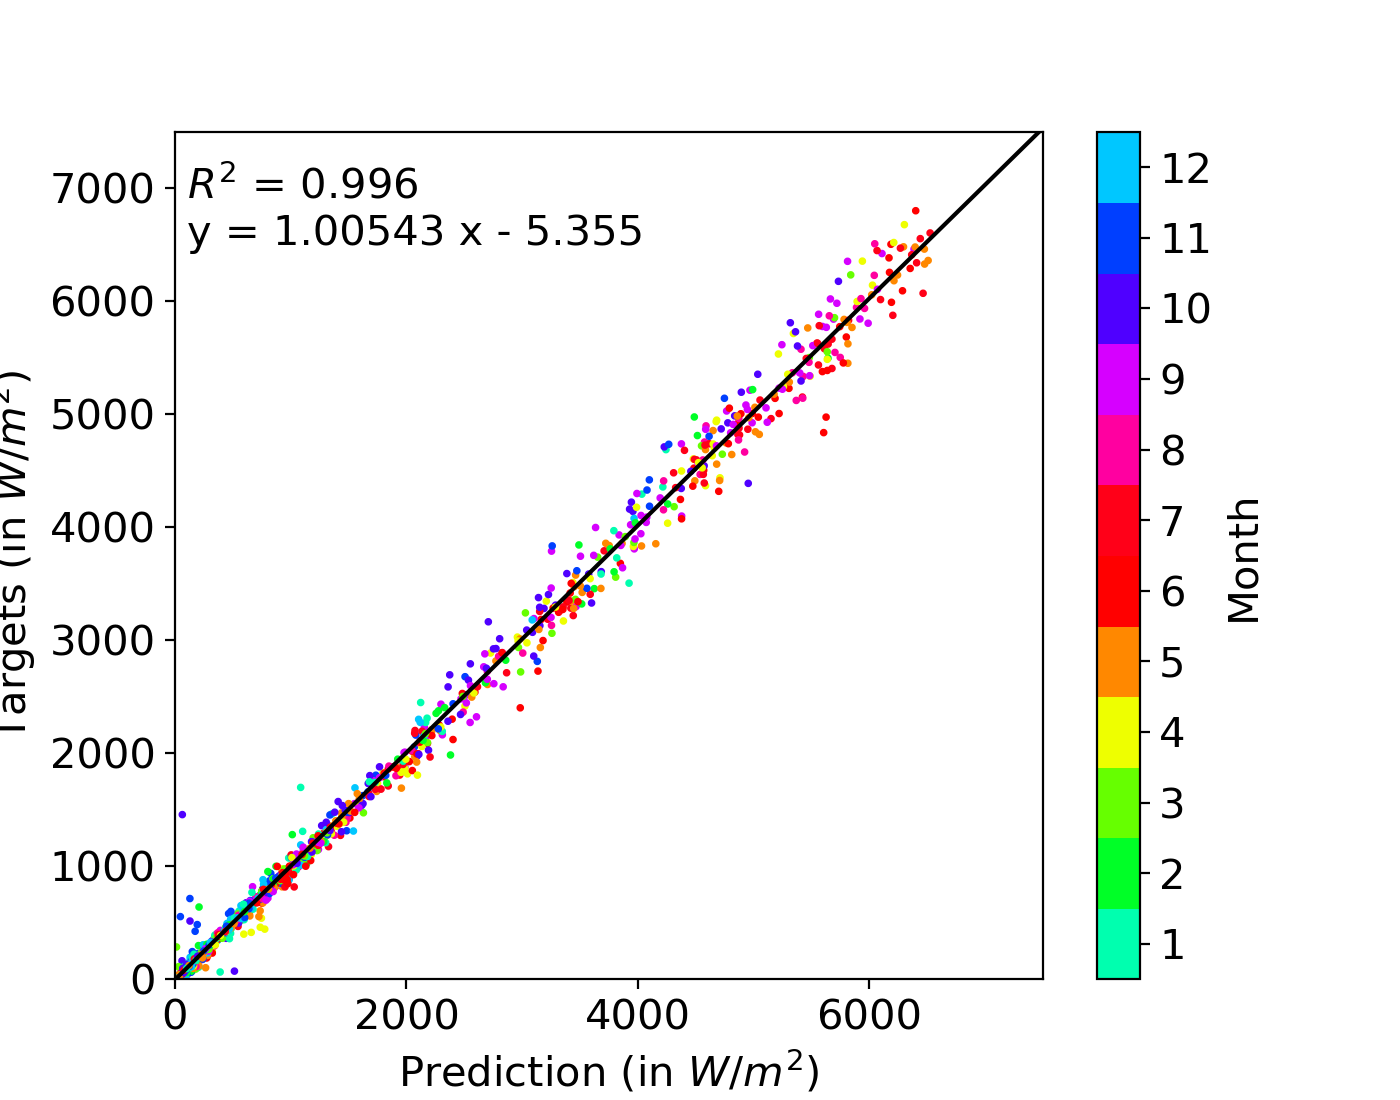

In [27]:
months = hourly_aggregation.iloc[ind[tr_n : ]].reset_index().set_index('date').index.month
lab_tic = np.linspace(1,12,25)[1::2]

plt.figure(figsize = (7,5.5))
matplotlib.rcParams.update({'font.size': 15}) 
plt.plot(linX,linY, 'k', LineWidth = 1.5)
plt.scatter(test_pred, test_tgts, s=3, c=months, cmap=discrete_cmap(12)) #, norm=norm)
plt.ylabel('Targets (in $W/m^2$)')
plt.xlabel('Prediction (in $W/m^2$)')
# plt.axis('equal')
plt.ylim(0, lim)
plt.xlim(0, lim)
plt.text(100, 6500, ("$R^2$ = %.3f\ny = %.5f x - %.3f" %(R2, coef, abs(intcpt))) )
# plt.title('Distribution of targets and prediction for test data')
cbar = plt.colorbar(ticks=lab_tic)
cbar.ax.set_yticklabels([('%d' %(i+1)) for i in range(len(lab_tic))])
cbar.set_label('Month')
plt.show()
#plt.savefig('corr_test_data.png', dpi = 300)

### THINK ABOUT ONLINE LEARNING!